# Scalable Gradients for Neural Stochastic Differential Equations

The main contributions of this work is introduce an adjoint method for Ito and Stratonovich stochastic differntial equations.

## Ito Stochastic Differential Equations

Formally, assume that we have a stochastic process $\{Z_T\}_{t \in \mathbb{T}}$ with Gaussian noise. We can represent this stochastic with a Ito stochastic differential equation. Ito SDEs are all of the form

$$Z_T = z_0 + \int^T_0 b(Z_t, t) dt + \sum_{i=1}^m \int_0^T \sigma(Z_t, t) dW_t$$

* $z_0$ is the initial state.
* $W_t$ is a Wiener Process (or [Brownian Motion](https://en.wikipedia.org/wiki/Brownian_motion#Mathematics)) 
* $b: \mathbb{R}^d \times \mathbb{R} \rightarrow \mathbb{R}^d$ is called the **drift function**. 
* $\sigma_i: \mathbb{R}^d \times \mathbb{R} \rightarrow \mathbb{R}^d$ is called a **diffusion function** and represents the noise in our system (for simplicity $m$ is often set to 1 so there is only one diffusion function $\sigma$)

## Neural SDEs

In the neural SDE formulation, we will model the drift function $b$ as a neural network $f(z, t, \theta)$ and the diffusion functio $\sigma$ as another neural network $\sigma(z, t, \theta)$. Li et al. address **three problems for neural SDEs**.

1. **Defining the Adjoint method for SDEs**
2. **Querying the Wiener Process $W$ during the backward pass***
3. **Formulating a loss function for SDEs**

## Backward Pass For Neural SDEs

## Backwards Startonovich Integral (Section 2.4)

Recently, Li et al. extended the adjoint sensitivity method for ODEs to SDEs. Therefore, the gradients can be computed by solving a [Stratonovich](https://en.wikipedia.org/wiki/Stratonovich_integral#Definition) SDE that runs backward in time, and intermediate gradients do not have to be stored. The whole derivation of the backward integral can be found in the Section 2.4 of Li et al. Briefly, the forward integral can written in the Stratonovich form as such

![forwardIntegral](./media/forwardIntegral.png)


Let us denote $\{\widecheck{W}_t\}_{t \in T}$ as the backwards Wiener process defined by $\widecheck{W}_t = W_t - W_T$ adapted to backwards filtration $\{\mathcal{F}_{t,T}\}_{t \in T}$. For a continuous semimartingale $\check{Y}_t$ adapted to backwards filtration, the backwards Stratonovich integral is

![backwardsIntegral](./media/backwardsIntegral.png)

## Adjoint Sensitivity for Neural SDEs (Sections 2.5 and 3)

The pseudocode comparison of Neural ODEs and Neural SDEs is shown below. Notice that the adjoint method is similar to the adjoint method for ODEs. However, **we must compute the adjoints of two functions: the drift and the diffusion functions** and use an SDE solver rather than an ODE Solver.

![neuralSDEAdjoint](media/neuralSDEAdjoint.png)


## Virtual Brownian Tree (Section 4)

Notice in the pseudocode above, we need some way to query the Wiener process $w(t)$ for different values of $t$ while we are performing the backward pass. The authors accomplish this with a **Brownian Tree** in logarithmic time. The Brownian tree allows you to recursively query for the value of Wiener process at time $t$ without having to store these noise values in the forward pass.

![brownTree](./media/BrownianTree.png)

The algorithmn requires the usage of a pseudorandom number generator to generate scalars which the Li et al. call keys. Specifially, it must implement the following function `split` which generates two keys given one existing key. Another function `BrownianBridge` is then used to sample from the normal distribution.

![brownbridge](./media/brownbridge.png)

The algorithm begins by sampling the Wiener process values at the initial time and terminal time. The algorithm then recursively samples from the midpoint of [Brownian bridges](https://en.wikipedia.org/wiki/Brownian_bridge). Each new sample uses a key generated by `split` from the parent node. The full pseudocode is give below

![brownalgo](./media/browntreealgo.png)


## Variational Loss for Neural SDEs (Section 5)

Another limitation of Neural SDEs is that maxmizing the likelihood will cause the diffusion function to go to 0. Li et al. propose using variational inference to optimize Neural SDEs. Namely, a prior over functions and an approximate posterior are each parameterized using an SDE.

Prior: $dz_p = f_\theta(z(t))\ dt + \sigma_\theta(z(t))\ dW(t)$

Approximate Posterior: $dz_q = f_\phi(z(t))\ dt + \sigma_\theta(z(t))\ dW'(t)$

Note that both the prior and approximate posterior must have the same diffusion function. We can then optimize the evidenced lower bound (ELBO) as derived below. The first term is the KL term and the second term is the log likelihood.

$$\mathcal{L} = \mathbb{E} \: [\frac{1}{2}\int^T_0 |u(Z_t, t)|^2 dt + \sum_{i=1}^N log p (y_{t_i} | z_{t_i})]$$

where $u$ is 

$$u(Z_t, t) = |\frac{f_\theta(z(t)) - f_\phi(z(t))}{\sigma_\theta(z(t))}|^2_2$$

## Functions Modelled by Latent SDE

For the 50-dimensional motion capture dataset (23 walking sequences partitioned into training, validation, and test), the paper learns 5 different functions each parameterized as separate neural networks summarized below.

1. Encoder: $x_0, x_1, x_2 \rightarrow \mu_{z_0}, \sigma_{z_0}, \text{context}$
2. Decoder: $z_t \rightarrow \mu_{x_t}, \sigma_{x_t}$
3. Prior Drift Function: $z_t, t \rightarrow \text{Prior Drift}$
4. Posterior Drift: $z_t, t, \text{context} \rightarrow \text{Posterior Drift}$
5. Diffusion Function: $z_t^{(i)}, t \rightarrow \sigma_i$ (Note there is one diffusion function neural network for each dimension of latent space)

**Notation**

* $x_t$: the $t$th frame
* $\mu_{z_0}$: mean of initial latent state
* $\sigma_{z_0}$: log variance of initial latent state
* $\mu_{x_t}$: mean of decoded latent state
* $\sigma_{x_t}$: log variance of decoded latent state
* $\text{context}$: context vector passed from encoder to posterior drift
* $z_t$: the latent state of $x_t$
* $z_t^{(i)}$": element in $i$th dimension of $z_t$
* $t$: scalar representing time 
* $\sigma_i$: Diagonal diffusion element for $i$th latent dimension

![neuralarch](./media/neuralarchitecture.png)

## Limitations of Current Neural SDE Methods

* SDEs with non-diagonal noise are very costly to compute. In Li et al., they restrict themselves to SDEs with diagonal noise.
* Maximum Likelihood maximization results in overfitting and diffusion function $\sigma$ goes to 0

# Latent Neural SDE Examples

## Torchsde Library

Torchsde provides the *sdeint* function and to numerically integrate Ito or Stratonovich SDEs. TThe *sdeint_adjoint* function is equivalent except it uses the adjoint method for the backward pass. Both sdeint and sdeint_adjoint take an an object with the drift and diffusion functions defined as member functions `f` and `g`. Torchsde provides the following integration methods

* Ito solvers
    * [Euler-Maruyama](https://en.wikipedia.org/wiki/Euler%E2%80%93Maruyama_method)
    * [Milstein](https://en.wikipedia.org/wiki/Milstein_method)
    * [Stochastic Runge-Kutta](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_method_(SDE))
* Stratonovich solvers
    * [Euler-Heun](https://infoscience.epfl.ch/record/143450/files/sde_tutorial.pdf) (Section 2.2.2)
    * [Heun's Method](https://en.wikipedia.org/wiki/Heun%27s_method)
    * [Midpoint Method](https://en.wikipedia.org/wiki/Midpoint_method)
    * [Milstein Method](https://en.wikipedia.org/wiki/Milstein_method)
    * [Reversible Heun](https://arxiv.org/pdf/2105.13493.pdf)
    * [Adjoint Reversible Heun](https://arxiv.org/pdf/2105.13493.pdf)

**A full documentation** of torchsde with argument definitions and trade-offs between the different solvers can be found [here](https://github.com/google-research/torchsde/blob/master/DOCUMENTATION.md).


## Plotting the mean and noise separately

For simplicity, let us consider an SDE with the drift and diffusion, $f$ and $g$, defined below

$$f(t, y) = sin(t) + \theta \cdot y$$
$$g(t, y) = 0.3 * \frac{1}{1 + e^{(cos(t) \cdot e^{-y}))}}$$

where $\theta$ is a scalar equal to 0.1. We can plot samples from the SDE, its mean, and its noise shown below. The drift term was separated by using torchdiffeq's [*odeint*](https://github.com/rtqichen/torchdiffeq#keyword-arguments-for-odeint_adjoint) function to solve just the drift as the following ODE.

$$z_0 + \int^T_0 b(Z_t, t) dt$$

The diffusion term was solved by using an SDE solver to solve an SDE with the diffusion term but the drift function and inital value of $0$ (i.e. setting argeument `y0` and `name` argument to a drift function that always returns 0).

$$\int^T_0 0 \  dt + \sum_{i=1}^m \int_0^T \sigma(Z_t, t) dW_t$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import MDAnalysis as mda
import torch
import torchsde
# import torchdiffeq

from neuralSDE import NeuralSDE
from utils import plot

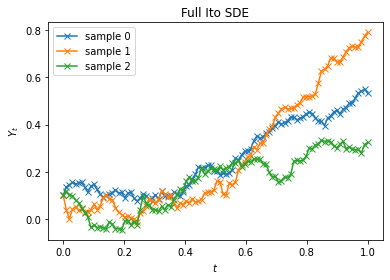

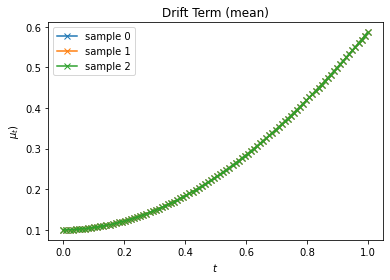

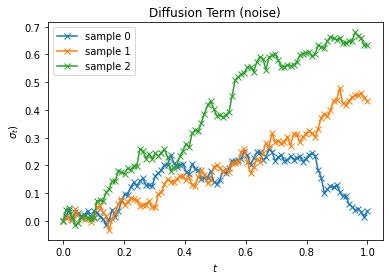

In [3]:
# Set data
batch_size, state_size, t_size = 3, 1, 100
ts = torch.linspace(0, 1, t_size)
y0 = torch.full(size=(batch_size, state_size), fill_value=0.1)

sde = NeuralSDE(state_size, batch_size)
with torch.no_grad():
    ys = torchsde.sdeint(sde, y0, ts, method='euler')  # (t_size, batch_size, state_size) = (100, 3, 1)
    mean = sde.compute_mean(ts, y0=y0)
    noise = sde.compute_noise(ts)


plot(ts, ys, xlabel='$t$', ylabel='$Y_t$', title="Full Ito SDE")
plot(ts, mean, xlabel='$t$', ylabel='$\mu_t)$', title="Drift Term (mean)")
plot(ts, noise, xlabel='$t$', ylabel='$\sigma_t)$', title="Diffusion Term (noise)")


## Lorentz Attractor Example